In [ ]:
!pip install scikit-fuzzy > /dev/null 2>&1

In [ ]:
#@title Libraries
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control
import random
import pickle
from time import sleep
import logging
from datetime import datetime
import uuid
import pandas as pd
import datetime
import math
from sklearn.model_selection import train_test_split
import copy
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#@title CLEAN DATA
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
file_data = "/content/gdrive/My Drive/BA Learning/battery_dataset_complete_B0018.csv"

B = pd.read_csv(file_data)
dfB = B.iloc[:, list([0,4,8,9,10]) ]
dfB = dfB.copy()
dfB['acc_time'] = dfB['time'].cumsum()

def clean_data(df):
    # Remove rows with NaN values
    df = df.dropna()

    # Remove rows where 'voltage_measured' or 'voltage_load' is 0
    #df = df[(df['voltage_measured'] != 0) & (df['voltage_load'] != 0)]
    df = df[(df['voltage_measured'] != 0) & (df['voltage_load'] != 0) & (df['voltage_load'] != 0)]

    # Remove outliers using IQR
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Adjust this condition according to your needs
    df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

    return df

# Usage example:
dfB_cleaned = clean_data(dfB)

# Extracting the features and target variable
#train_data = dfB_cleaned[['voltage_measured', 'voltage_load', 'cycle', 'target_soh']]
X = dfB_cleaned[['cycle','voltage_measured', 'voltage_load', 'acc_time']]
y = dfB_cleaned['target_soh']
## Split data into training and test sets
proportion_data_test = 0.5
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False, test_size=proportion_data_test, random_state=42)

X_normalised = X.copy()
y_normalised = y.copy()

columns_to_normalise = ['voltage_measured', 'voltage_load', 'acc_time']
columns_to_normalise2 = ['voltage_measured', 'voltage_load', 'acc_time','target_soh']

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

dfB_cleaned_normalised = dfB_cleaned.copy()
dfB_cleaned_normalised.loc[:, columns_to_normalise2] = scaler.fit_transform(dfB_cleaned_normalised[columns_to_normalise2])

dfB_cleaned_normalised['acc_time']=np.where(dfB_cleaned_normalised['acc_time'] < 1.0, np.ceil(dfB_cleaned_normalised['acc_time'] / 0.001) * 0.001, 1.0)

X_normalised = dfB_cleaned_normalised[['voltage_measured', 'voltage_load', 'acc_time']]
y_normalised = dfB_cleaned_normalised['target_soh']

#X_normalised.loc[:, columns_to_normalise] = scaler.fit_transform(X_normalised[columns_to_normalise])
#y_normalised = y_normalised.values.reshape(-1, 1)
#y_normalised = scaler.fit_transform(y_normalised)

X_train_normalised, X_test_normalised, y_train_normalised, y_test_normalised = train_test_split(X_normalised,y_normalised, shuffle=False, test_size=proportion_data_test, random_state=42)

Mounted at /content/gdrive


In [ ]:
#@title FUNCTIONS TO SET MEMBERSHIPS AND RULES FROM DATA
class Fuzzify(object):
    def __init__(self, data_series, Min, Max, Mid):
        """Create a triangular membership function with a data series and its max, min and median"""

        self.data = data_series
        self.low = Min
        self.high = Max
        self.mid = Mid
        self.universe = np.arange(np.floor(self.low), np.ceil(self.high)+0.2, 0.01)
        self.trimf_low  = fuzz.trimf(self.universe, [self.low, self.low, self.mid])
        self.trimf_mid = fuzz.trimf(self.universe, [self.low, self.mid, self.high+0.1])
        self.trimf_hi  =  fuzz.trimf(self.universe, [self.mid, self.high+0.1, self.high+0.1])

    def get_universe(self):
        return self.universe

    def get_membership(self):
        """Assign fuzzy membership to each observation in the data series and return a dataframe of the result"""

        new_df = pd.DataFrame(self.data)
        new_df['L'] = fuzz.interp_membership(self.universe, self.trimf_low, self.data)
        new_df['M'] = fuzz.interp_membership(self.universe, self.trimf_mid, self.data)
        new_df['H'] = fuzz.interp_membership(self.universe, self.trimf_hi, self.data)
        new_df['membership'] = new_df.loc[:, ['L', 'M', 'H']].idxmax(axis = 1)
        new_df['degree'] = new_df.loc[:, ['L', 'M', 'H']].max(axis = 1)
        return new_df

#def get_rule(train_data, *arg):
#    """ return the final fuzzy rule given any number of input data columns"""

#    rule_df = train_data.copy()
#    rule_df['degree'] = np.ones(train_data.shape[0])
#    for col in rule_df.columns[:-1]:
#        idx = train_data.columns.get_loc(col)
#        rule_df[col] = arg[idx]['membership']
#        rule_df['degree'] *=  arg[idx]['degree']
#    final_rule = rule_df.groupby(list(rule_df.columns[:-1])).max()
#    final_rule = final_rule.reset_index()
#    return final_rule

def get_rule(train_data, *arg):
    """ return the final fuzzy rule given any number of input data columns"""

    rule_df = train_data.copy()
    rule_df['degree'] = np.ones(train_data.shape[0])
    for col in rule_df.columns[:-1]:
        idx = train_data.columns.get_loc(col)
        rule_df[col] = arg[idx]['membership']
        rule_df['degree'] *=  arg[idx]['degree']
    final_rule = rule_df.groupby(list(rule_df.columns[:-1])).max()
    final_rule = final_rule.reset_index()
    return final_rule

In [ ]:
#
VoltM = dfB_cleaned_normalised.iloc[:,1]

VoltM_min = VoltM.min()
VoltM_max =  VoltM.max()
VoltM_mid =  np.median(np.arange(VoltM_min, VoltM_max, 0.1))

VoltM_object = Fuzzify(VoltM, VoltM_min, VoltM_max, VoltM_mid)
fuzzified_VoltM = VoltM_object.get_membership()


In [ ]:
#
VoltL = dfB_cleaned_normalised.iloc[:,2]

VoltL_min = VoltL.min()
VoltL_max =  VoltL.max()
VoltL_mid =  np.median(np.arange(VoltL_min, VoltL_max, 0.1))

VoltL_object = Fuzzify(VoltL, VoltL_min, VoltL_max, VoltL_mid)
fuzzified_VoltL = VoltL_object.get_membership()#

In [ ]:
#
tm = dfB_cleaned_normalised['acc_time']

tm_min = tm.min()
tm_max =  tm.max()
tm_mid =  np.median(np.arange(tm_min, tm_max, 0.001))

tm_object = Fuzzify(tm, tm_min, tm_max, tm_mid)
fuzzified_tm = tm_object.get_membership()

In [ ]:
#
H = dfB_cleaned_normalised.iloc[:,4]

H_min = H.min()
H_max =  H.max()
H_mid =  np.median(np.arange(H_min, H_max, 0.1))

H_object = Fuzzify(H, H_min, H_max, H_mid)
fuzzified_H = H_object.get_membership()

In [ ]:
fuzzified_VoltM

,voltage_measured,L,M,H,membership,degree
2,0.980751,0.000000,0.183460,0.816540,H,0.816540
3,0.965303,0.000000,0.207227,0.792773,H,0.792773
4,0.953171,0.000000,0.225890,0.774110,H,0.774110
5,0.942893,0.000000,0.241704,0.758296,H,0.758296
6,0.933802,0.000000,0.255689,0.744311,H,0.744311
...,...,...,...,...,...,...
34831,0.097645,0.783012,0.216988,0.000000,L,0.783012
34832,0.078576,0.825387,0.174613,0.000000,L,0.825387
34833,0.057663,0.871860,0.128140,0.000000,L,0.871860
34834,0.035178,0.921826,0.078174,0.000000,L,0.921826


In [ ]:
fuzzified_VoltL

,voltage_load,L,M,H,membership,degree
2,0.971904,0.000000,0.197070,0.802930,H,0.802930
3,0.968783,0.000000,0.201873,0.798127,H,0.798127
4,0.957336,0.000000,0.219483,0.780517,H,0.780517
5,0.946930,0.000000,0.235492,0.764508,H,0.764508
6,0.938606,0.000000,0.248299,0.751701,H,0.751701
...,...,...,...,...,...,...
34831,0.093652,0.791883,0.208117,0.000000,L,0.791883
34832,0.074922,0.833507,0.166493,0.000000,L,0.833507
34833,0.053070,0.882067,0.117933,0.000000,L,0.882067
34834,0.031217,0.930628,0.069372,0.000000,L,0.930628


In [ ]:
fuzzified_tm

,acc_time,L,M,H,membership,degree
2,0.000,1.0,1.000000,0.000000,L,1.000000
3,0.001,0.9,0.999091,0.000909,M,0.999091
4,0.001,0.9,0.999091,0.000909,M,0.999091
5,0.001,0.9,0.999091,0.000909,M,0.999091
6,0.001,0.9,0.999091,0.000909,M,0.999091
...,...,...,...,...,...,...
34831,1.000,0.0,0.090909,0.909091,H,0.909091
34832,1.000,0.0,0.090909,0.909091,H,0.909091
34833,1.000,0.0,0.090909,0.909091,H,0.909091
34834,1.000,0.0,0.090909,0.909091,H,0.909091


In [ ]:
fuzzified_H

,target_soh,L,M,H,membership,degree
2,1.0,0.0,0.153846,0.846154,H,0.846154
3,1.0,0.0,0.153846,0.846154,H,0.846154
4,1.0,0.0,0.153846,0.846154,H,0.846154
5,1.0,0.0,0.153846,0.846154,H,0.846154
6,1.0,0.0,0.153846,0.846154,H,0.846154
...,...,...,...,...,...,...
34831,0.0,1.0,0.000000,0.000000,L,1.000000
34832,0.0,1.0,0.000000,0.000000,L,1.000000
34833,0.0,1.0,0.000000,0.000000,L,1.000000
34834,0.0,1.0,0.000000,0.000000,L,1.000000


In [ ]:
# Specifying the new column order
new_column_order = ['cycle', 'voltage_measured', 'voltage_load', 'acc_time', 'target_soh']

# Reordering the DataFrame columns
dfB_cleaned_normalised = dfB_cleaned_normalised[new_column_order]

In [ ]:
# Drop the 'cycle' column
dfB_cleaned_R = dfB_cleaned_normalised.drop('cycle', axis=1)


In [ ]:
R = get_rule(dfB_cleaned_R, fuzzified_VoltM, fuzzified_VoltL, fuzzified_tm, fuzzified_H)
#R_important = R[R['degree'] >= 0]



In [ ]:
R

,voltage_measured,voltage_load,acc_time,target_soh,degree
0,H,H,H,L,0.543605
1,H,H,H,M,0.336488
2,H,H,L,H,0.554759
3,H,H,M,H,0.553614
4,H,H,M,M,0.388858
5,L,L,H,L,0.875467
6,L,L,H,M,0.486764
7,L,L,M,H,0.801246
8,L,L,M,M,0.555224
9,L,M,H,L,0.174208


In [ ]:
# Assuming your data is stored in a DataFrame named 'df'
R['degree'] = pd.to_numeric(R['degree'])

# Group by 'voltage_measured', 'voltage_load', and 'acc_time' columns
# Then, keep the row with the highest 'degree' value within each group
R_important = R.groupby(['voltage_measured', 'voltage_load', 'acc_time'], group_keys=False).apply(lambda group: group[group['degree'] == group['degree'].max()])

# Reset the index to maintain the original table structure
R_important = R_important.reset_index(drop=True)

In [ ]:
R_important

,voltage_measured,voltage_load,acc_time,target_soh,degree
0,H,H,H,L,0.543605
1,H,H,L,H,0.554759
2,H,H,M,H,0.553614
3,L,L,H,L,0.875467
4,L,L,M,H,0.801246
5,L,M,H,L,0.174208
6,L,M,M,H,0.217512
7,M,H,H,L,0.235088
8,M,H,M,H,0.224911
9,M,L,H,L,0.230037


In [ ]:
R_important2 = R_important[R_important['degree'] >= 0.5]

In [ ]:
# Convert the DataFrame to an array of tuples, excluding the 'degree' column # GANTI R
table_R = [tuple(row) for row in R_important2[['voltage_measured', 'voltage_load', 'acc_time', 'target_soh']].values]

# Print the array to check
print(table_R)

[('H', 'H', 'H', 'L'), ('H', 'H', 'L', 'H'), ('H', 'H', 'M', 'H'), ('L', 'L', 'H', 'L'), ('L', 'L', 'M', 'H'), ('M', 'M', 'H', 'L'), ('M', 'M', 'M', 'H')]


In [ ]:
#@title Bees Algorithm Initial Setting Parameters
# settings
n = 5
nep = 10

nVar = 1

# Setting Parameters of Bees Algorithm
varMin = [VoltM_object.low]*nVar + [VoltL_object.low]*nVar + [tm_object.low]*nVar +  [H_object.low]*nVar
varMax = [VoltM_object.high]*nVar + [VoltL_object.high]*nVar + [tm_object.high]*nVar + [H_object.high]*nVar


In [ ]:
#@title BA'S FUNCTIONS
def generate_initial_solution(nVar):
    # For a's: nVar random numbers between [0, 180], then sort them
    a_vars = np.sort(np.random.uniform(VoltM_object.low, VoltM_object.high, nVar))

    # For b's: nVar random numbers between [0, 18], then sort them
    b_vars = np.sort(np.random.uniform(VoltL_object.low, VoltL_object.high, nVar))

    # For c's: nVar random numbers between [0, 1.5], then sort them
    c_vars = np.sort(np.random.uniform(tm_object.low, tm_object.high, nVar))

    # For c's: nVar random numbers between [0, 1.5], then sort them
    d_vars = np.sort(np.random.uniform(H_object.low, H_object.high, nVar))

    # Combine all the variables
    solution = np.concatenate((a_vars, b_vars, c_vars, d_vars))
    return solution

def integrated_foraging(x, ass, Vmx, Vmn, sh):
    ngh = np.random.triangular(0, ass, 1)
    Vmx = np.array(Vmx)
    Vmn = np.array(Vmn)
    r = ngh * (Vmx-Vmn) * sh
    nVar = len(x)
    #print(nVar)
    y = np.array(x)

    r = ngh * (Vmx-Vmn) * sh

    y = y + np.random.uniform(-r, r, size=(1, nVar))

    y = y.flatten()  # Flatten the array

    for i in range (nVar):
        if y[i] < Vmn[i]:
            y[i] = Vmn[i]
        if y[i] > Vmx[i]:
            y[i] = Vmx[i]

    return y

def sort_every_n(lst,nVar):
    # Split the list into chunks of nVar
    chunks = [lst[i:i+nVar] for i in range(0, len(lst), nVar)]
    # Sort each chunk
    sorted_chunks = [sorted(chunk) for chunk in chunks]
    # Flatten the list of sorted chunks
    return [item for sublist in sorted_chunks for item in sublist]

class Bee:
    def __init__(self, position, cost):
        self.position = position
        self.cost = cost

In [ ]:
#@title COST FUNCTION (1-R2)
def make_prediction(system, row):
    simulation = control.ControlSystemSimulation(system)
    simulation.input['Var1'] = row['voltage_measured']
    simulation.input['Var2'] = row['voltage_load']
    simulation.input['Var3'] = row['acc_time']
    simulation.compute()
    return simulation.output['PVar1']

def COST (X_sample, y_sample, A, B, C, D,converted_R):
    In_1 = control.Antecedent(A.universe, 'Var1')
    In_2 = control.Antecedent(B.universe, 'Var2')
    In_3 = control.Antecedent(C.universe, 'Var3')

    Out_1 = control.Consequent(D.universe, 'PVar1')

    In_1['L']=fuzz.trimf(In_1.universe,[A.low,A.low,A.mid])
    In_1['M']=fuzz.trimf(In_1.universe,[A.low,A.mid,A.high])
    In_1['H']=fuzz.trimf(In_1.universe,[A.mid,A.high,A.high])

    In_2['L']=fuzz.trimf(In_2.universe,[B.low,B.low,B.mid])
    In_2['M']=fuzz.trimf(In_2.universe,[B.low,B.mid,B.high])
    In_2['H']=fuzz.trimf(In_2.universe,[B.mid,B.high,B.high])

    In_3['L']=fuzz.trimf(In_3.universe,[C.low,C.low,C.mid])
    In_3['M']=fuzz.trimf(In_3.universe,[C.low,C.mid,C.high])
    In_3['H']=fuzz.trimf(In_3.universe,[C.mid,C.high,C.high])

    Out_1['L']=fuzz.trimf(Out_1.universe,[D.low,D.low,D.mid])
    Out_1['M']=fuzz.trimf(Out_1.universe,[D.low,D.mid,D.high])
    Out_1['H']=fuzz.trimf(Out_1.universe,[D.mid,D.high,D.high])

    rules = []
    for row in table_R:
        rule = control.Rule(In_1[row[0]] & In_2[row[1]] & In_3[row[2]], Out_1[row[3]])
        rules.append(rule)

    system = control.ControlSystem(rules)

    predicted_values = [make_prediction(system, row) for index, row in X_sample.iterrows()]

    # Calculate R^2 using sklearn's r2_score function
    r_squared = r2_score(y_sample, predicted_values)

    # Calculate MSE using sklearn's mean_squared_error function
    mse = mean_squared_error(y_sample, predicted_values)

    # Define weights for R^2 and MSE
    weight_r2 = 0.5
    weight_mse = 0.5

    # Combine R^2 and MSE into a single cost metric
    # Note: Since higher R^2 is better and lower MSE is better,
    # you might need to adjust the formula based on how you want to balance these metrics
    cost = weight_r2 * (1 - r_squared) + weight_mse * mse

    return cost

In [ ]:
#@title BA trains Fuzzy Engine
sample_size=200
# Convert y_train_normalised to a DataFrame and align its index with X_train_normalised
y_train_normalised_df = pd.DataFrame(y_train_normalised, columns=['target_soh'], index=X_train.index)

# Sample X_train_normalised
X_sample = X_train_normalised.sample(n=sample_size, random_state=1)

# Use the indices of X_sample to retrieve the corresponding rows from y_train_normalised_df
y_sample = y_train_normalised_df.loc[X_sample.index]

BVoltM_object = copy.copy(VoltM_object)
BVoltL_object = copy.copy(VoltL_object)
Btm_object = copy.copy(tm_object)
BH_object = copy.copy(H_object)

maxIt = 200
shrink = 1

BestCost = np.zeros(maxIt)
BestPos = [[] for _ in range(maxIt)]

recruitment = np.round(np.linspace(nep, 1, n)).astype(int)
ngh = np.linspace(0, 1, n)

# Initialization
bee = []

initial_solutions = [generate_initial_solution(nVar) for _ in range(n)]

for sol in initial_solutions:
    BVoltM_object.mid = sol[0]
    BVoltL_object.mid = sol[1]
    Btm_object.mid = sol[2]
    BH_object.mid = sol[3]
    Z=COST(X_sample, y_sample, BVoltM_object,BVoltL_object,Btm_object,BH_object,table_R)
    bee.append(Bee(sol, Z))

bee.sort(key=lambda b: b.cost)

# Main Loop
for it in range(maxIt):
    # Update I1, I2, and yz every 100 iterations
    if it % 50 == 0 and it != 0:
        X_sample = X_train_normalised.sample(n=sample_size, random_state=1)
        y_sample = y_train_normalised_df.sample(n=sample_size, random_state=1)
    # All Sites
    for i in range(n):
        bestnewbee = Bee([], math.inf)
        assigntment = np.linspace(0, 1, recruitment[i])

        for j in range(recruitment[i]):
            temp_position = integrated_foraging(bee[i].position, assigntment[j], varMax, varMin, shrink)
            BVoltM_object.mid = temp_position[0]
            BVoltL_object.mid = temp_position[1]
            Btm_object.mid = temp_position[2]
            BH_object.mid = temp_position[3]
            new_cost = COST(X_sample, y_sample, BVoltM_object,BVoltL_object,Btm_object,BH_object,table_R)
            if new_cost < bestnewbee.cost:
                bestnewbee = Bee(temp_position, new_cost)

        if bestnewbee.cost < bee[i].cost:
            bee[i] = bestnewbee

    shrink = shrink * 1
    bee.sort(key=lambda x: x.cost)
    BestSol = bee[0]
    BestCost[it] = BestSol.cost
    BestPos[it] = BestSol.position

    # Display Iteration Information
    print('Iteration {}: Best Cost = {}: Best Position = {}'.format(it, BestCost[it], BestPos[it]))


Iteration 0: Best Cost = 0.1457012629229444: Best Position = [0.53710126 0.76425014 0.16352609 0.70797351]
Iteration 1: Best Cost = 0.1457012629229444: Best Position = [0.53710126 0.76425014 0.16352609 0.70797351]
Iteration 2: Best Cost = 0.1457012629229444: Best Position = [0.53710126 0.76425014 0.16352609 0.70797351]
Iteration 3: Best Cost = 0.14335537750209368: Best Position = [0.99668652 1.         0.17164446 0.69096322]
Iteration 4: Best Cost = 0.14335537750209368: Best Position = [0.99668652 1.         0.17164446 0.69096322]
Iteration 5: Best Cost = 0.14335537750209368: Best Position = [0.99668652 1.         0.17164446 0.69096322]
Iteration 6: Best Cost = 0.14335537750209368: Best Position = [0.99668652 1.         0.17164446 0.69096322]
Iteration 7: Best Cost = 0.14335537750209368: Best Position = [0.99668652 1.         0.17164446 0.69096322]
Iteration 8: Best Cost = 0.14335537750209368: Best Position = [0.99668652 1.         0.17164446 0.69096322]
Iteration 9: Best Cost = 0.1433

In [ ]:
BestPos[it-1]
AA = copy.copy(VoltM_object)
BB = copy.copy(VoltL_object)
CC = copy.copy(tm_object)
DD = copy.copy(H_object)
AA.mid=BestPos[it-1][0]
BB.mid=BestPos[it-1][1]
CC.mid=BestPos[it-1][2]
DD.mid=BestPos[it-1][3]

In [ ]:
In1 = control.Antecedent(AA.universe, 'Var1')
In2 = control.Antecedent(BB.universe, 'Var2')
In3 = control.Antecedent(CC.universe, 'Var3')

Out1 = control.Consequent(DD.universe, 'PVar1')

In1['L']=fuzz.trimf(In1.universe,[AA.low,AA.low,AA.mid])
In1['M']=fuzz.trimf(In1.universe,[AA.low,AA.mid,AA.high])
In1['H']=fuzz.trimf(In1.universe,[AA.mid,AA.high,AA.high])

In2['L']=fuzz.trimf(In2.universe,[BB.low,BB.low,BB.mid])
In2['M']=fuzz.trimf(In2.universe,[BB.low,BB.mid,BB.high])
In2['H']=fuzz.trimf(In2.universe,[BB.mid,BB.high,BB.high])

In3['L']=fuzz.trimf(In3.universe,[CC.low,CC.low,CC.mid])
In3['M']=fuzz.trimf(In3.universe,[CC.low,CC.mid,CC.high])
In3['H']=fuzz.trimf(In3.universe,[CC.mid,CC.high,CC.high])

Out1['L']=fuzz.trimf(Out1.universe,[DD.low,DD.low,DD.mid])
Out1['M']=fuzz.trimf(Out1.universe,[DD.low,DD.mid,DD.high])
Out1['H']=fuzz.trimf(Out1.universe,[DD.mid,DD.high,DD.high])

    # Define fuzzy rules
rules = []
for row in table_R:
    rule = control.Rule(In1[row[0]] & In2[row[1]] & In3[row[2]], Out1[row[3]])
    rules.append(rule)

system = control.ControlSystem(rules)

In [ ]:
BestPos[it]

array([0.3282342 , 0.39249313, 0.16196783, 0.70320027])

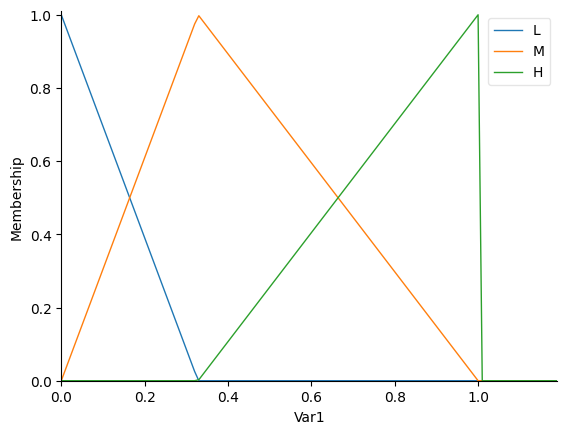

In [ ]:
In1.view()

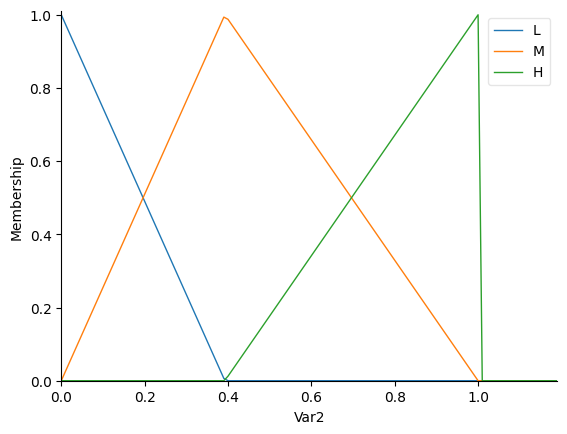

In [ ]:
In2.view()

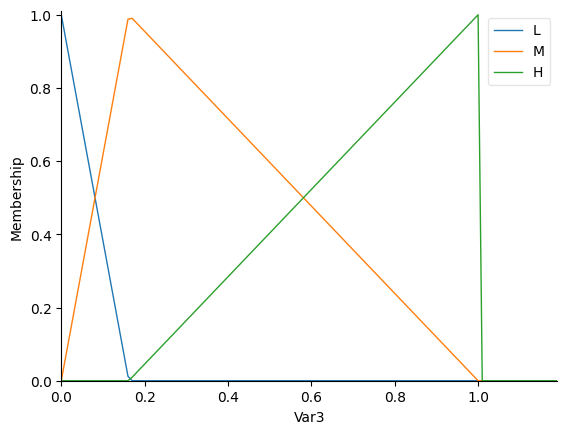

In [ ]:
In3.view()

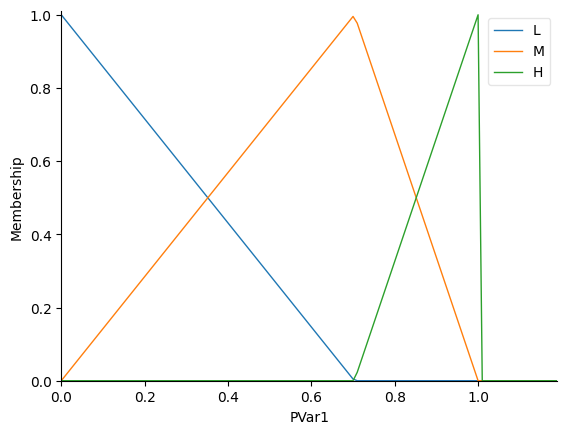

In [ ]:
Out1.view()

In [ ]:
y_test_normalised_pred = [make_prediction(system, row) for index, row in X_test_normalised.iterrows()]

In [ ]:
y_train_normalised_pred = [make_prediction(system, row) for index, row in X_train_normalised.iterrows()]

In [ ]:
y_test_normalised_pred_0 = [make_prediction(system_0, row) for index, row in X_test_normalised.iterrows()]

In [ ]:
y_train_normalised_pred_0 = [make_prediction(system_0, row) for index, row in X_train_normalised.iterrows()]

In [ ]:
#@title INVERSE NORMALISATION
def inverse_min_max_scaling(y_pred_normalized, min_val, max_val):
    # Ensure y_pred_normalized is a numpy array
    y_pred_normalized = np.array(y_pred_normalized)

    # Convert min_val and max_val to numpy arrays if they aren't already
    min_val = np.array(min_val)
    max_val = np.array(max_val)

    # Ensure that min_val and max_val are scalars or have the same shape as y_pred_normalized
    if min_val.shape != y_pred_normalized.shape:
        min_val = np.full_like(y_pred_normalized, min_val)
    if max_val.shape != y_pred_normalized.shape:
        max_val = np.full_like(y_pred_normalized, max_val)

    return y_pred_normalized * (max_val - min_val) + min_val

In [ ]:
y_test_pred_original = inverse_min_max_scaling(y_test_normalised_pred, y_test.min(), y_test.max())

In [ ]:
y_train_pred_original = inverse_min_max_scaling(y_train_normalised_pred, y_train.min(), y_train.max())

In [ ]:
y_test_pred_original_0 = inverse_min_max_scaling(y_test_normalised_pred_0, y_test.min(), y_test.max())

In [ ]:
y_train_pred_original_0 = inverse_min_max_scaling(y_train_normalised_pred_0, y_train.min(), y_train.max())

In [ ]:
train_mae = mean_absolute_error(y_train_normalised, y_train_normalised_pred)
train_mape = mean_absolute_percentage_error(y_train_normalised, y_train_normalised_pred)
train_rms = np.sqrt(mean_squared_error(y_train_normalised, y_train_normalised_pred))
train_mse = mean_squared_error(y_train_normalised, y_train_normalised_pred)
train_r2 = r2_score(y_train_normalised, y_train_normalised_pred)
print('Mean Absolute Error: ', train_mae)
print('Mean Absolute Percentage Error: ', train_mape)
print('Root Mean Square Error: ', train_rms)
print('R2 Scored: ', train_r2)
print('Mean Square Error: ', train_mse)

Mean Absolute Error:  0.05307946987552983
Mean Absolute Percentage Error:  0.07185883089720452
Root Mean Square Error:  0.07066006538623795
R2 Scored:  0.7665081603577297
Mean Square Error:  0.004992844840387423


In [ ]:
train_mae2 = mean_absolute_error(y_test_normalised, y_test_normalised_pred)
train_mape2 = mean_absolute_percentage_error(y_test_normalised, y_test_normalised_pred)
train_rms2 = np.sqrt(mean_squared_error(y_test_normalised, y_test_normalised_pred))
train_mse2 = mean_squared_error(y_test_normalised, y_test_normalised_pred)
train_r2_2 = r2_score(y_test_normalised, y_test_normalised_pred)
print('Mean Absolute Error: ', train_mae2)
print('Mean Absolute Percentage Error: ', train_mape2)
print('Root Mean Square Error: ', train_rms2)
print('R2 Scored: ', train_r2_2)
print('Mean Square Error: ', train_mse2)

Mean Absolute Error:  0.16588000536916517
Mean Absolute Percentage Error:  12344161273615.611
Root Mean Square Error:  0.18271814319660065
R2 Scored:  -0.41176610723659723
Mean Square Error:  0.03338591985321346


Text(0.5, 1.0, 'Discharge B0018')

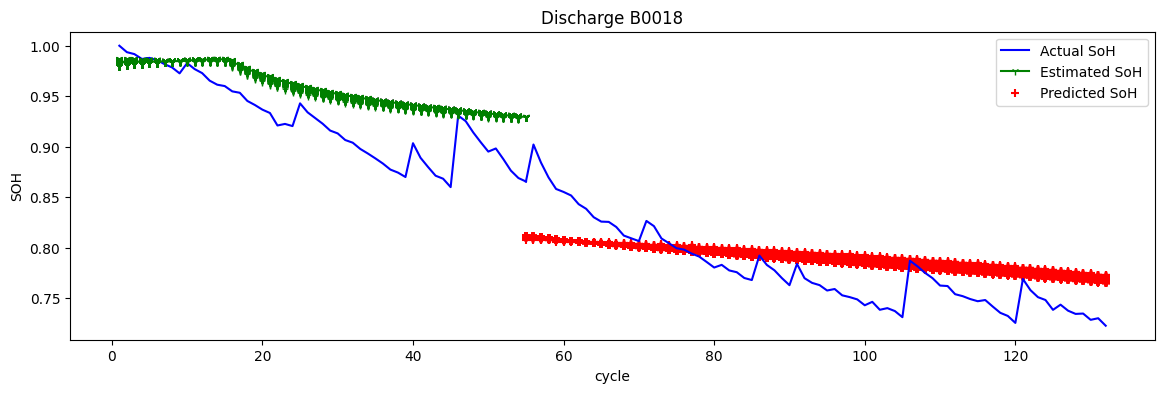

In [ ]:
#@title PLOT
MX_train=X_train.copy()
MX_test=X_test.copy()

MX_train = pd.concat([X_train, y_train], axis=1)
MX_test = pd.concat([X_test, y_test], axis=1)

# Create DataFrames from the predictions
y_pred_df1 = pd.DataFrame(y_train_pred_original, columns=['predictions'], index=X_train.index)
y_pred_df2 = pd.DataFrame(y_test_pred_original, columns=['predictions'], index=X_test.index)

# Concatenate predictions with the corresponding datasets
MX_train = pd.concat([X_train, y_train, y_pred_df1], axis=1)
MX_test = pd.concat([X_test, y_test, y_pred_df2], axis=1)

plt.figure(figsize=(14, 4))
plt.plot(MX_train['cycle'], MX_train['target_soh'], label='Actual SoH', c='blue')
plt.plot(MX_train['cycle'], MX_train['predictions'], marker='1', label='Estimated SoH', c='green')

#plt.scatter(new_soh_te['cycle'], new_soh_te['SoHtest'], label='SoH test', c='green')

plt.plot(MX_test['cycle'], MX_test['target_soh'], c='blue')
plt.scatter(MX_test['cycle'], MX_test['predictions'], marker='+', label='Predicted SoH', c='red')

#plt.plot(new_soh_te['cycle'], new_soh_te['NewSoHtest'], label='SoH test pred')

plt.ylabel('SOH')
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0018')